In [1]:
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.data import Dataset, TFRecordDataset

from sklearn.model_selection import train_test_split
import keras

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, MaxPool2D
from tensorflow.keras import backend as K
from scipy.ndimage import zoom


import keras_tuner as kt

## Data Pre-processing

#### import the data of time series and y label

In [2]:
import pickle
with open ('time_series_1.pickle', 'rb') as handle:
    time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle', 'rb') as handle:
    time_series_2 = pickle.load(handle)
with open ('y.pickle', 'rb') as handle:
    y = pickle.load(handle)
with open ('y.pickle', 'rb') as handle:
    y_plot = pickle.load(handle)

#### Sequence to Vector

Sequence is defined as a particular order in which related things follow each other. For x in this case are two time series, which will be precedence and precedence, so we treat this as Sequence. while the output is the mode of wind turbines with multiple classes. We feed the time sequence of inputs and map only last output of one dimension with 4 classes, so it is applied wuth Sequence-to-Vector method (also called an encoder). There are several approaches to convert y data points into a vector.

1. Regarding all the models we used below, within the final layer, we use softmax activaciton function because softmax could use to predict the probability by logistic regression for each class.
2. the error between the expected and predicted value of multionmial probablity is the cross entropy loss caclulated within the function, which is the difference between probablity distribution as compiling the model.
3. the error would also be used to calculate the gradient of the model and the model would be updated.

Here we change the y from (1,2,3,0) to ((0,1,0,0),(0,0,1,0),(0,0,0,1),(1, 0,0,0). The reason why using one-hot encoding is that the final Dense layer we would use softmax to have 4 number of categorical output, to choose the highest probablity as its category. Also when we conpile the model compile loss would also use ="categorical_crossentropy"

In [3]:
nb_classes = 4
y_one_hot = y.astype(int)
y_one_hot_targets = np.eye(nb_classes)[y_one_hot]
y = y_one_hot_targets

#### Trian, Validation, Test spliting
One thing worth mentioning is that we did not scale the two time series:
1. After we looked at the distribution of data, we found that in two separate time series, the values between different time periods are not significantly different
2. We are worried that if the scaling is finished, the important information of some time periods will be lost, which will be detrimental to the learning of NN
So we keep the original data and use shuffle to randomly collect the observation index, and split it into datasets of train with 75%, validation with 15%, and test with 15%

In [4]:
np.random.seed(123)
idx = np.arange(len(time_series_1))
np.random.shuffle(idx) # randomly collect the observation index

train = 2800
val = 600
test = 600
train_idxs = idx[:train]
val_idxs = idx[train:train+val]
test_idxs = idx[train+val:train+val+test]

train_time_series_1 = time_series_1[train_idxs]
val_time_series_1 = time_series_1[val_idxs]
test_time_series_1 = time_series_1[test_idxs]

train_time_series_2 = time_series_2[train_idxs]
val_time_series_2 = time_series_2[val_idxs]
test_time_series_2 = time_series_2[test_idxs]

y_train = y[train_idxs]
y_val = y[val_idxs]
y_test = y[test_idxs]

#### Create a empty dataframe to record the result and compare
the dataframe would be used for question 6 for comparison and choosing the best model

In [142]:
df_model_record_trn_accuracy  = pd.DataFrame()
df_model_record_val_accuracy = pd.DataFrame()
df_model_record_trn_loss = pd.DataFrame()
df_model_record_val_loss = pd.DataFrame()

## Question 1	
**Create a recurrent neural network in TensorFlow to predict the operating mode of a wind turbine based on the two time series(俯仰角跟扭矩) from the sensors. Before any implementation, carefully consider what type of approach (sequence-to-vector, sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to manipulate the data, given that you have two different time series for each observation.Then, make sure that you try out the different layers and elements discussed in class, such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be necessary, it is recommended that you tune your network systematically. Make sure to record your final validation set accuracy.**

### BenchMark of simple layers with using different methods
(i.e. SimpleRNN, LSTM, Conv1D, and GRU)
Here we first test in the same layers (1 layer of input, 1 layer of layerord of method we applied, 1 layer of softmax output). To compare the efficiency, learning curve, loss and accuracy of different methods in train and valiadaiton
1. After having such a benchmark comparison, perform a superposition on layers that perform better or have similar structure.
2. After compare the BenchMark model and deduce the reason, we could build and test the Optimal Model

Why do we need to stack time_series_1 with time_series_2 is because in SimpleRNN, LSTM, Conv1D, and GRU models:
1. Its input layer shape is input_shape=[None, 2]: None means we analyze the entire time series, 2 means we have two dimensions (which is time_series_1 and time_series_2)
2. The reason why the two time series are superimposed is because we found that both 0 if the turbine is healthy and 3 if both are faulty in the output y label need to consider the conditions of the two time periods

In [144]:
# stack the time series
# the time series are stacked as [observation, time_steps, features]
# column would be using axis=2,
merged_array_trn = np.stack([train_time_series_1, train_time_series_2], axis=2)
merged_array_val = np.stack([val_time_series_1, val_time_series_2], axis=2)
merged_array_test = np.stack([test_time_series_1, test_time_series_2], axis=2)
merged_array_trn.shape, merged_array_val.shape, merged_array_test.shape

((2800, 5000, 2), (600, 5000, 2), (600, 5000, 2))

#### Method 1: simple RNN

RNN will be weighted and memorized according to the previous information, so the information of the entire time period will be included in the last unit, which can be regarded as the feature vector extracted from the two time periods. This is why time series is suitable for this scenario:
1. Due to the simple internal structure of simpleRNN and low requirements for computing resources, compared with the RNN variants we will use later: LSTM and GRU model parameters, the total number of parameters is much less (this model is only with 1,364), and the calculation time is relatively low to save time.
2. Simple RNN is only suitable for short-term dependence. But its disadvantage is that it is not good at long-term dependence. If too many time series are accumulated, the important information will be diluted (often abnormal calculation of gradient, or gradient disappearance or explosion)

 With 20 epcchs, we can observe 
 1. loss: 0.6900 
 2. accuracy: 0.7429 
 3. val_loss: 0.7184
 4. val_accuracy: 0.7133 
 5. The execution time of each epoch is about 265 seconds


In [ ]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [7]:
# create tensorflow model
model_simpleRNN = Sequential([ 
    SimpleRNN(20, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(20),
    Dense(4, activation="softmax")
    ])

learning_rate = 0.001
model_simpleRNN.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]) # sparse_categorical_crossentropy

model_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          460       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 1,364
Trainable params: 1,364
Non-trainable params: 0
_________________________________________________________________


2022-04-14 11:17:50.038025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
epochs = 20 
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_simpleRNN = model_simpleRNN.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
                # callbacks = [early_stopping_cb]
                )
# log.history['loss']

Epoch 1/20
88/88 [==============================] - 269s 3s/step - loss: 1.3946 - accuracy: 0.2875 - val_loss: 1.3668 - val_accuracy: 0.3667
Epoch 2/20
88/88 [==============================] - 261s 3s/step - loss: 1.3470 - accuracy: 0.3371 - val_loss: 1.3255 - val_accuracy: 0.3700
Epoch 3/20
88/88 [==============================] - 255s 3s/step - loss: 1.3102 - accuracy: 0.3821 - val_loss: 1.2806 - val_accuracy: 0.4117
Epoch 4/20
88/88 [==============================] - 272s 3s/step - loss: 1.2482 - accuracy: 0.4446 - val_loss: 1.2065 - val_accuracy: 0.4733
Epoch 5/20
88/88 [==============================] - 263s 3s/step - loss: 1.1484 - accuracy: 0.5332 - val_loss: 1.0762 - val_accuracy: 0.5517
Epoch 6/20
88/88 [==============================] - 263s 3s/step - loss: 1.0310 - accuracy: 0.5600 - val_loss: 0.9803 - val_accuracy: 0.5917
Epoch 7/20
88/88 [==============================] - 261s 3s/step - loss: 0.9353 - accuracy: 0.6171 - val_loss: 0.9073 - val_accuracy: 0.6367
Epoch 8/20
88

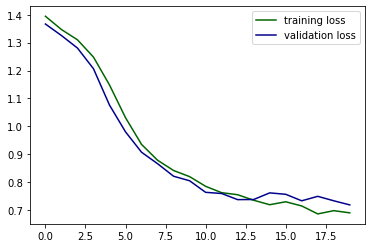

In [9]:
plt.plot(log_simpleRNN.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_simpleRNN.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

#### Method 2: LSTM

1. Compare LSTMs to SimpleRNN, as mentioned in our method1: RNN has the problem that it cannot solve long-term dependencies. In order to solve the above problems, LSTM (Long Short-Term Memory) is proposed, which realizes the temporal memory function and prevents the gradient from disappearing by switching the cell gate (input, output, and forget gate and through the sigmiod function to decide).
2. Disadvantages: Due to the relatively complex internal structure, the training efficiency is much lower than that of simpleRNN under the same computing power.

It is worth noting here that in order to allow simpleRNN, LSTM, and GRU to be compared and because of time efficiency, we set the Epoch of the four methods to 20 (because simpleRNN will not continue to grow when the epoch is almost 20). ). We also tried LSTM with 30 epochs and set early_stopping_cb, its accuracy is about 0.63

 With 20 epcchs, we can observe
 1. loss: 0.8763 
 2. accuracy: 0.6164 
 3. val_loss: 0.9074 
 4. val_accuracy: 0.6067 
 5. The execution time of each epoch is about 420 seconds

In [191]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [74]:
model_LSTM = Sequential([
    LSTM(20, return_sequences=True, input_shape=[None, 2]),
    #BatchNormalization(), # We tried it and it didn't make much difference
    LSTM(20,input_shape=[None, 2]),
    Dense(4, activation="softmax")
])

learning_rate = 0.001
model_LSTM.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1840      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 5,204
Trainable params: 5,204
Non-trainable params: 0
_________________________________________________________________


In [75]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_LSTM= model_LSTM.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 3445s 40s/step - loss: 1.3717 - accuracy: 0.3225 - val_loss: 1.2946 - val_accuracy: 0.3967
Epoch 2/20
88/88 [==============================] - 418s 5s/step - loss: 1.2771 - accuracy: 0.4114 - val_loss: 1.2475 - val_accuracy: 0.4317
Epoch 3/20
88/88 [==============================] - 416s 5s/step - loss: 1.2421 - accuracy: 0.4318 - val_loss: 1.2191 - val_accuracy: 0.4433
Epoch 4/20
88/88 [==============================] - 416s 5s/step - loss: 1.2211 - accuracy: 0.4432 - val_loss: 1.2107 - val_accuracy: 0.4550
Epoch 5/20
88/88 [==============================] - 415s 5s/step - loss: 1.2049 - accuracy: 0.4504 - val_loss: 1.1969 - val_accuracy: 0.4450
Epoch 6/20
88/88 [==============================] - 416s 5s/step - loss: 1.2089 - accuracy: 0.4550 - val_loss: 1.1949 - val_accuracy: 0.4550
Epoch 7/20
88/88 [==============================] - 420s 5s/step - loss: 1.1877 - accuracy: 0.4686 - val_loss: 1.2186 - val_accuracy: 0.4367
Epoch 8/20


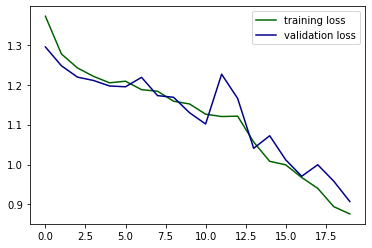

In [76]:
plt.plot(log_LSTM.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_LSTM.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

#### Method 3: GRU

Compare GRU to LSTMs:\
GRU: two gates (reset and update gates)\
LSTMs: three gates (input, output and forget gates)\
1. As method2 said, the problem of LSTM is that the execution speed is slow, so GRU replaces the forget gate and input gate in LSTM with an update gate, and merges the cell state (cell state) and the hidden state (ht)
2. So theoretically, Gated Recurrent Unit is used to speed up execution and reduce mem

 With 20 epcchs, we can observe 
 1. loss: 0.7023 
 2. accuracy: 0.7196 
 3. val_loss: 0.7825 
 4. val_accuracy: 0.6833 
 5. The execution time of each epoch is about 450 seconds

From the actual execution results of GRU and LSTM, it can be found that there is little difference between GRU and LSTM (apporximately 420 second per epoch) in execution seconds, and even GRU is slightly slower (apporximately 450 second per epoch), although there is a theoretical difference. slightly contradictory
1. Many articles have stated that LSTM and GRU have advantages and disadvantages in different materials and tasks, depending on the situation.
2. But it may be due to the computer cache (we ran LSTM first and then GRU, and did not restart Kernal), causing GRU to be relatively slow
But in general, the difference between the two models is not large, both of which are used to improve the problem of simpleRNN's poor performance in long-term memory, and even the accuracy of GRU will be higher, so we apply GRU to the RNN optimal model below.

In [77]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [78]:
model_GRU = Sequential([
    GRU(20, return_sequences=True, input_shape=[None, 2]),
    GRU(20),
    Dense(4, activation="softmax")
])

learning_rate = 0.001
model_GRU.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])

model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1440      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 4,044
Trainable params: 4,044
Non-trainable params: 0
_________________________________________________________________


In [79]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_GRU= model_GRU.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 452s 5s/step - loss: 1.3773 - accuracy: 0.2889 - val_loss: 1.3585 - val_accuracy: 0.3283
Epoch 2/20
88/88 [==============================] - 442s 5s/step - loss: 1.3253 - accuracy: 0.3554 - val_loss: 1.3039 - val_accuracy: 0.3600
Epoch 3/20
88/88 [==============================] - 451s 5s/step - loss: 1.2621 - accuracy: 0.4039 - val_loss: 1.2781 - val_accuracy: 0.3267
Epoch 4/20
88/88 [==============================] - 450s 5s/step - loss: 1.1885 - accuracy: 0.4639 - val_loss: 1.1654 - val_accuracy: 0.4517
Epoch 5/20
88/88 [==============================] - 449s 5s/step - loss: 1.1459 - accuracy: 0.4954 - val_loss: 1.1128 - val_accuracy: 0.4867
Epoch 6/20
88/88 [==============================] - 452s 5s/step - loss: 1.1028 - accuracy: 0.5143 - val_loss: 1.0719 - val_accuracy: 0.5183
Epoch 7/20
88/88 [==============================] - 448s 5s/step - loss: 1.0683 - accuracy: 0.5257 - val_loss: 1.0855 - val_accuracy: 0.5183
Epoch 8/20
88

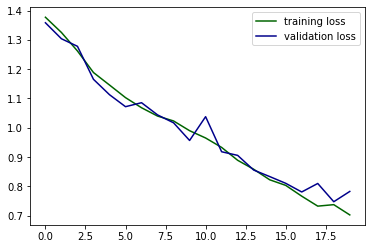

In [80]:
plt.plot(log_GRU.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_GRU.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

### Based on the BenchMark to add more layers into our model

#### Better performing model: Mixing with one input layer of Conv1D and 2 layer of GRU

When we are using GRU or LSTM, the biggest problem is that the execution time is too long. At this time, we can use One-dimensional Convolutional Layer to reduce dimensions :
1. kernel_size=4 is equivalent to a 4*4 kernel array, filter into a unit of features.
2. strides=2 means that every time the next filter is taken down, the index needs an interval of 2
3. for instance: (6*6 image)*(3*3 kernel with 1 strides) would have the output of (4*4 image)

You can think of the current input as data that is no longer a time series, but a photo with only one dimension. By Conv1D, we could extract features from sequences of times without missing the signals. Simultaneously drop down the input to the next layers and increasing the computing efficiency

 With 20 epcchs, we can observe 
 1. loss: 0.7023 
 2. accuracy: 0.7196 
 3. val_loss: 0.7825 
 4. val_accuracy: 0.6833 
 5. The execution time of each epoch is about 450 seconds

Compared with only GRU or LSTM, we can find that the accuracy rate has indeed improved a lot, but the overall efficiency is still insufficient. The purpose of Conv1D is to improve the efficiency without missing the extracted features. So we think one more Conv1D layer can reduce the dimensions and also improve the accuracy and efficiency.

In [192]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [193]:
model_1D_GRU = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), # kernel_size=4, It means that there are four time points values are combined into one unit
    #BatchNormalization(), # We tried it and it didn't make much difference
    GRU(20, return_sequences=True, input_shape=[None, 2]),
    GRU(20),
    Dense(4, activation="softmax")
])

learning_rate = 0.001
model_1D_GRU.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"])

model_1D_GRU.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 gru (GRU)                   (None, None, 20)          2520      
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 5,304
Trainable params: 5,304
Non-trainable params: 0
_________________________________________________________________


In [194]:
epochs = 20
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_1D_GRU= model_1D_GRU.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
                callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 229s 3s/step - loss: 1.3451 - accuracy: 0.3500 - val_loss: 1.3003 - val_accuracy: 0.4217
Epoch 2/20
88/88 [==============================] - 223s 3s/step - loss: 1.2370 - accuracy: 0.4854 - val_loss: 1.2066 - val_accuracy: 0.4950
Epoch 3/20
88/88 [==============================] - 222s 3s/step - loss: 1.1295 - accuracy: 0.5543 - val_loss: 1.1616 - val_accuracy: 0.4867
Epoch 4/20
88/88 [==============================] - 224s 3s/step - loss: 1.0094 - accuracy: 0.6021 - val_loss: 0.9376 - val_accuracy: 0.6233
Epoch 5/20
88/88 [==============================] - 221s 3s/step - loss: 0.8876 - accuracy: 0.6364 - val_loss: 0.8209 - val_accuracy: 0.6633
Epoch 6/20
88/88 [==============================] - 218s 2s/step - loss: 0.7966 - accuracy: 0.6807 - val_loss: 0.7412 - val_accuracy: 0.6933
Epoch 7/20
88/88 [==============================] - 222s 3s/step - loss: 0.7024 - accuracy: 0.7243 - val_loss: 0.6962 - val_accuracy: 0.6917
Epoch 8/20
88

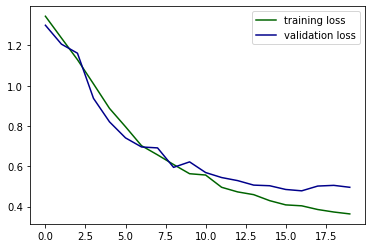

In [195]:
plt.plot(log_1D_GRU.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_1D_GRU.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

#### Optimal model1: 3 layer Conv1D + 2 layer of GRU
As mentioned above, adding a layer of Conv1D layer can lead to an increase in the accuracy of the model. However, the effect of efficiency by adding one layer is not the best at present. After continuous testing, it is matched with GRU layers:
1. Add two layers of Conv1D to improve the efficiency of the model, and observe the changes in accuracy and loss at the same time to confirm that the accuracy of the model has not decreased
2. Increase the number of units of GRU to 150 (compared with the original 20 for both layers, its accuracy is increased by 3% on validation set)
In general, such adjustments can improve the efficiency of the model and improve the accuracy of the model, and the results are as follows, and are recorded back into the dataframe

 With 20 epcchs, we can observe 
 1. loss: 0.1531 
 2. accuracy: 0.9307 
 3. val_loss: 0.3225 
 4. val_accuracy: 0.8567 
 5. The execution time of each epoch is about 74 seconds


1. Compared with the previous model, both val_accuracy and val_loss have been significantly improved: it is confirmed that the effect of adding two new Conv1D layers does not reduce the accuracy of the model
2. The number of units in the GRU layer is increased by 150, and the accuracy is increased by 3%
3. In terms of time, from the original 210 seconds to 74 seconds per epoch

Overall, this RNN model performs well

In [145]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [146]:
model_optimal = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), #new added
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), #new added
    GRU(150, return_sequences=True, input_shape=[None, 2]), # new added with 150 neurons
    GRU(20),
    Dense(4, activation="softmax")
])

learning_rate = 0.001
model_optimal.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]) 

model_optimal.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru (GRU)                   (None, None, 150)         77400     
                                                                 
 gru_1 (GRU)                 (None, 20)                10320     
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 91,224
Trainable params: 91,224
Non-traina

In [147]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_optimal = model_optimal.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 83s 905ms/step - loss: 1.0899 - accuracy: 0.5400 - val_loss: 0.8148 - val_accuracy: 0.6433
Epoch 2/20
88/88 [==============================] - 78s 883ms/step - loss: 0.5839 - accuracy: 0.8025 - val_loss: 0.4479 - val_accuracy: 0.8450
Epoch 3/20
88/88 [==============================] - 75s 853ms/step - loss: 0.3263 - accuracy: 0.8918 - val_loss: 0.3169 - val_accuracy: 0.8833
Epoch 4/20
88/88 [==============================] - 77s 874ms/step - loss: 0.2959 - accuracy: 0.8871 - val_loss: 0.3571 - val_accuracy: 0.8700
Epoch 5/20
88/88 [==============================] - 74s 838ms/step - loss: 0.2728 - accuracy: 0.8993 - val_loss: 0.2972 - val_accuracy: 0.8800
Epoch 6/20
88/88 [==============================] - 1059s 12s/step - loss: 0.2411 - accuracy: 0.9043 - val_loss: 0.2655 - val_accuracy: 0.8850
Epoch 7/20
88/88 [==============================] - 78s 886ms/step - loss: 0.2251 - accuracy: 0.9086 - val_loss: 0.2629 - val_accuracy: 0.8883

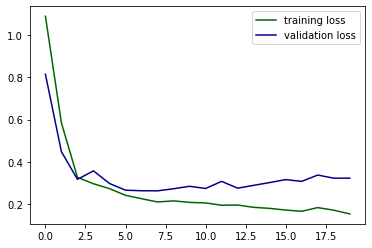

In [148]:
plt.plot(log_optimal.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_optimal.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# the plot shows this is a bit overfitting, but in order to have the same consistency (most of the model won't be overfitting)

This is the optimal model, which is the better performance of the above model above and we thought it might be applied to the Question6 final evulation\
So we further recorded the result to dataframe.

In [149]:
df_model_record_val_accuracy['log_optimal'] = log_optimal.history['val_accuracy']
df_model_record_val_loss['log_optimal'] = log_optimal.history['val_loss']
df_model_record_trn_accuracy['log_optimal'] = log_optimal.history['accuracy']
df_model_record_trn_loss['log_optimal'] = log_optimal.history['loss']

#### Optimal model2: 3 layer Conv1D + 2 layer of LSTM

Remember that when we simply used GRU or LSTM as the BenchMark model, we found that the time efficiency and accuracy were similar, so for better comparison, we changed the GRU layer of the above model to LSTM layers, the result as follows:

3 layer Conv1D + 2 layer of LSTM:

 With 20 epcchs, we can observe 
 1. loss: 0.1761 
 2. accuracy: 0.9218 
 3. val_loss: 0.3289 
 4. val_accuracy: 0.8583 
 5. The execution time of each epoch is about 84 seconds

3 layer Conv1D + 2 layer of GRU:

 With 20 epcchs, we can observe 
 1. loss: 0.1531 
 2. accuracy: 0.9307 
 3. val_loss: 0.3225 
 4. val_accuracy: 0.8567 
 5. The execution time of each epoch is about 74 seconds


Comparision:
1. The val_loss in the layer Conv1D + 2 LSTM model is higher than the layer Conv1D + 2 layer GRU
2. The Validation accuracy of layer Conv1D + 2 LSTM is similar to that of layer Conv1D + 2 layer GRU model
3. The calculation time is 74 seconds per epoch with layer Conv1D + 2 layer GRU is faster
4. Both have a problem with overfitting when epoch is set to 20, which will be noticed in Question6

This model is also recorded in the dataframe and used for comparison in the final evaluation of Question6

In [150]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [151]:
model_optimal2 = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), # strides= 2, 每兩個跳一下(可以看一下老師的瞅瞅的text
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]), 
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    LSTM(150,  return_sequences=True,input_shape=[None, 1]),
    LSTM(20),
    Dense(4, activation="softmax")
])

learning_rate = 0.001
model_optimal2.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=["accuracy"]) 

model_optimal2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 lstm (LSTM)                 (None, None, 150)         102600    
                                                                 
 lstm_1 (LSTM)               (None, 20)                13680     
                                                                 
 dense (Dense)               (None, 4)                 84        
                                                                 
Total params: 119,784
Trainable params: 119,784
Non-trai

In [152]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_optimal2 = model_optimal2.fit(merged_array_trn, y_train, 
                epochs=epochs,
                validation_data=(merged_array_val, y_val),
#                 callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 85s 928ms/step - loss: 1.2605 - accuracy: 0.4104 - val_loss: 1.0952 - val_accuracy: 0.5033
Epoch 2/20
88/88 [==============================] - 76s 863ms/step - loss: 0.9524 - accuracy: 0.6011 - val_loss: 0.7823 - val_accuracy: 0.7083
Epoch 3/20
88/88 [==============================] - 78s 883ms/step - loss: 0.6701 - accuracy: 0.7493 - val_loss: 0.5870 - val_accuracy: 0.7650
Epoch 4/20
88/88 [==============================] - 77s 873ms/step - loss: 0.4812 - accuracy: 0.8293 - val_loss: 0.4273 - val_accuracy: 0.8350
Epoch 5/20
88/88 [==============================] - 77s 879ms/step - loss: 0.3521 - accuracy: 0.8761 - val_loss: 0.3564 - val_accuracy: 0.8633
Epoch 6/20
88/88 [==============================] - 80s 906ms/step - loss: 0.3098 - accuracy: 0.8896 - val_loss: 0.3370 - val_accuracy: 0.8617
Epoch 7/20
88/88 [==============================] - 75s 857ms/step - loss: 0.2678 - accuracy: 0.8996 - val_loss: 0.3073 - val_accuracy: 0.8783

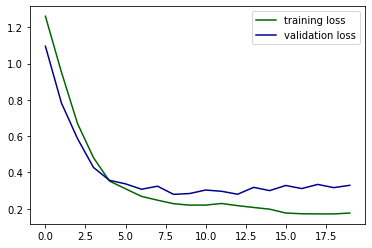

In [153]:
plt.plot(log_optimal2.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_optimal2.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

This is the optimal model, which is the better performance of the above model above and we thought it might be applied to the Question6 final evulation\
So we further recorded the result to dataframe.

In [154]:
df_model_record_val_accuracy['log_optimal2'] = log_optimal2.history['val_accuracy']
df_model_record_val_loss['log_optimal2'] = log_optimal2.history['val_loss']
df_model_record_trn_accuracy['log_optimal2'] = log_optimal2.history['accuracy']
df_model_record_trn_loss['log_optimal2'] = log_optimal2.history['loss']

## Question 2
**In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs.** 

Looking at the model building in the research paper, we can find several differences from RNN:
1. non-linearity can output unique values(independent components): thus would increasing the accuracy of the classficaiton) and can also help in the problems with noisy conditions.
2. convolutional layer fix the the problems with noisy conditions (extract the feature signals).
3. MaxPooling: is extracting the signals with the highest value and will strength the signal.
4. in all, CNN can discover and extract the suitable internal structure to generate deep features of the input time series automatically by using convolution and pooling operations.


Comparing with the foundmental calculating structure of RNN and CNN:
1. CNNs are computationally cheaper than RNNs: CNN learns by batch while RNNs train sequentially (with time series step by steps). As such, RNN can’t use parallelization because it must wait for the previous computations.
2. CNNs don’t have the assumption that history is complete: Unlike RNNs, CNNs learn patterns within the time window. If you have missing data, CNNs should be useful.
3. In a way, CNNs can look forward (exploit “spatial correlation” in data): RNN models only learn from data before the timestep it needs to predict. CNNs (with shuffling) can see data from a broader perspective.

## Question 3
**Convert the data for use with a CNN. In particular, following the approach outlined in Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a gray- scale image).**

In [5]:
import pickle
with open ('y.pickle', 'rb') as handle:
    y_CNN = pickle.load(handle)

# Convert class vectors to one-hot encoding
y_CNN = tf.keras.utils.to_categorical(y_CNN)
y_CNN

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

#### transform the data into different dimensions
1. The reason why we set img_rows, img_cols, img_channels = 100, 50, 1 is that we would like to add the two time series into a single image, and the image would be 100*100, so we set the img_rows = 100, img_cols = 50, img_channels = 1. And as the Research paper did, we applied the append of axis=2 (columns add after) to have single image to (100,100,1)\
2. note here we need a gray- scale image, so we set img_channels = 1. (if RGB image, we would set img_channels = 3)

In [6]:
img_rows, img_cols, img_channels = 100, 50, 1# input image dimensions

# Depending on the implementation, the underlying libraries might want the image 
if K.image_data_format() == 'channels_first':
    time_series_1_reshape = time_series_1.reshape(time_series_1.shape[0],img_channels, img_rows, img_cols)
    time_series_2_reshape = time_series_2.reshape(time_series_2.shape[0],img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    time_series_1_reshape = time_series_1.reshape(time_series_1.shape[0], img_rows, img_cols, img_channels)
    time_series_2_reshape = time_series_2.reshape(time_series_2.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

# dimensions in different orders, check for it and reshape
print('time_series_1_test shape:', time_series_1_reshape.shape)
print('time_series_2_test shape:', time_series_2_reshape.shape)

time_series_1_test shape: (4000, 100, 50, 1)
time_series_2_test shape: (4000, 100, 50, 1)


In [7]:
time_series_CNN = np.append(time_series_1_reshape, time_series_2_reshape , axis=2)
time_series_CNN.shape
# checking 
# time_series_CNN[0][0][0:5]

# # or use dstack could have the same result
# test = np.dstack((time_series_1_reshape, time_series_2_reshape))
# test.shape
# # # checking
# # test[0][0][0:5]

(4000, 100, 100, 1)

#### after transforming the data, split with the same seed and percentage for train, validation and test data

In [8]:
np.random.seed(123)
idx = np.arange(len(time_series_1))
np.random.shuffle(idx)

train = 2800
val = 600
test = 600

train_idxs = idx[:train]
val_idxs = idx[train:train+val]
test_idxs = idx[train+val:train+val+test]

x_CNN_trn = time_series_CNN[train_idxs]
x_CNN_val = time_series_CNN[val_idxs]
x_CNN_test = time_series_CNN[test_idxs]

y_CNN_trn = y_CNN[train_idxs]
y_CNN_val = y_CNN[val_idxs]
y_CNN_test = y_CNN[test_idxs]

print(x_CNN_trn.shape)
print(x_CNN_val.shape)
print(x_CNN_test.shape)
print(y_CNN_trn.shape)
print(y_CNN_val.shape)
print(y_CNN_test.shape)

(2800, 100, 100, 1)
(600, 100, 100, 1)
(600, 100, 100, 1)
(2800, 4)
(600, 4)
(600, 4)


## Question 4
**In TensorFlow, replicate the CNN with three convolutional layers displayed in Figure 12 and train it on your data. Make sure to record your final validation set accuracy.**

In [197]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

1. Step 1 : the input images are applied to a convolutional layer with the 20 kernels of 3*3 with 32 filters and 1 stride.
2. Step 2 : Convolutional layer with the 20 kernels of 3*3 with 32 filters and 2 stride. \
    (the reason for adding another layer is that, by adding a signal, which has high-frequency variation such as pitch angle in the wind turbine benchmark, it is better to increase the nonlinearity of the model in order to cope with this problem.)
3. Step 3 : Dropout of 0.2 layer\
    (see a Dropout layer is added to this structure. In Dropout layer, some of the neurons are simply droped out, since they are very similar to the other ones. This layer is a simple solution to prevent CNN from overfitting)
4. Step 4 : The outputs from convolved kernels are routed through a ReLu activation function. 
5. Step 5 : The next layer is a max pooling with the pools of 3 * 3. (The responsibility of this layer is to extract the strongest features.)
6. Step 6 : The last layer is an FCNN with a softmax function, which is used to classify the data.

In [198]:
input_shape = (100, 100, 1)
model_CNN = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=1, padding='valid',input_shape=input_shape), # Step 1 : the input images are applied to a convolutional layer with the 20 kernels of 3*3 with 32 filters and 1 stride.
    Conv2D(32, kernel_size=(3, 3),strides=2, padding='valid'), # Step 2 : Convolutional layer with the 20 kernels of 3*3 with 32 filters and 2 stride.
    tf.keras.layers.Dropout(rate=0.2), # Step 3 : Dropout of 0.2 layer
    Conv2D(16, kernel_size=(3, 3),strides=2, padding='valid',activation='relu'), # Step 4 : The outputs from convolved kernels are routed through a ReLu activation function.  
    MaxPooling2D(pool_size=(3,3)), # Step 5 : The next layer is a max pooling with the pools of 3 * 3. (The responsibility of this layer is to extract the strongest features.)
    Flatten(), # Step 6 : The last layer is an FCNN with a softmax function, which is used to classify the data.
    Dense(4, activation='softmax')])

model_CNN.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                        

In [199]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_CNN= model_CNN.fit(x_CNN_trn, y_CNN_trn, 
                epochs=epochs,
                validation_data=(x_CNN_val, y_CNN_val),
                # callbacks = [early_stopping_cb]
                )


Epoch 1/20
88/88 [==============================] - 10s 113ms/step - loss: 4.3199 - accuracy: 0.5496 - val_loss: 0.4548 - val_accuracy: 0.8450
Epoch 2/20
88/88 [==============================] - 10s 109ms/step - loss: 0.7492 - accuracy: 0.8043 - val_loss: 0.3928 - val_accuracy: 0.8833
Epoch 3/20
88/88 [==============================] - 9s 98ms/step - loss: 0.5844 - accuracy: 0.8411 - val_loss: 0.4198 - val_accuracy: 0.8717
Epoch 4/20
88/88 [==============================] - 8s 89ms/step - loss: 0.5475 - accuracy: 0.8571 - val_loss: 0.3630 - val_accuracy: 0.8767
Epoch 5/20
88/88 [==============================] - 8s 91ms/step - loss: 0.5233 - accuracy: 0.8504 - val_loss: 0.3367 - val_accuracy: 0.8867
Epoch 6/20
88/88 [==============================] - 8s 88ms/step - loss: 0.4825 - accuracy: 0.8571 - val_loss: 0.4241 - val_accuracy: 0.8850
Epoch 7/20
88/88 [==============================] - 8s 95ms/step - loss: 0.3745 - accuracy: 0.8746 - val_loss: 0.3275 - val_accuracy: 0.8833
Epoch 8/2

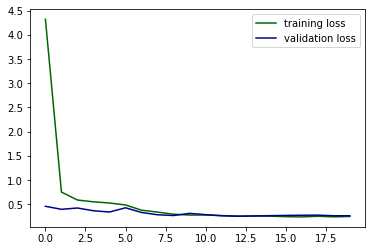

19/19 [==============================] - 0s 22ms/step - loss: 0.2564 - accuracy: 0.8667


[0.25639107823371887, 0.8666666746139526]

In [200]:
plt.plot(log_CNN.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_CNN.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# evalute the model on test set
model_CNN.evaluate(x_CNN_test, y_CNN_test)

However, the learning speed at the beginning is quite fast, indicating that it might be a direction to adjust the CNN model later.

But we would also record the performance of the model into the dataframe

In [159]:
df_model_record_val_accuracy['log_CNN'] = log_CNN.history['val_accuracy']
df_model_record_val_loss['log_CNN'] = log_CNN.history['val_loss']
df_model_record_trn_accuracy['log_CNN'] = log_CNN.history['accuracy']
df_model_record_trn_loss['log_CNN'] = log_CNN.history['loss']

## Question 5	
**Can you do better by adjusting the CNN? Be creative in your design choices (you might also consider pre-trained CNN architectures) and record your final validation set accuracy.**

1. Method 1: using the tuner to find the hyperparameters of the model and see whether it could be improved without changing the structure
2. Method 2: changing the structures on the research model (such as MaxPooling2D layers and BatchNormalization)
3. Method 3: using other pre-train model to comparing with Method 2

### Method 1: using tuner

1. We use tuner to find out the hyperparameters of the model and see if we can improve the results of the model without changing the structure of the model
2. The parameters that can be adjusted are:
     1. learning_rate: The setting range is 0.0001 to 0.01 to find the maximum value
     2. optimizer: choose one of 'sgd', 'adam'
     3. dropout_rate: The setting range is between 0.01 and 0.03 to find the maximum value
     4. num_filters within the convolutional layer:
         1. The first layer of Conv2D finds the maximum value in [3264,128]
         2. The second layer Conv2D finds the maximum value in [128, 64]
         3. The third layer Conv2D finds the maximum value in [64, 32]

The reason for this setting is that the subsequent Conv2D layer is not expected to have too many filters, because this will cause the complexity of the model to be too high, and it will cause excessive expansion during training.\
If there are too many filters in the front, it will cause an error that the input shape is wrong.

In [160]:
def train_model_RNN(hp):      

    # clean sessions and set seeds
    tf.keras.backend.clear_session()
    np.random.seed(231)
    tf.random.set_seed(631)
       
    num_filters1 = hp.Int('num_filters1', min_value=64, max_value=128, step=4)
    num_filters2 = hp.Int('num_filters2', min_value=32, max_value=64, step=4)
    num_filters3 = hp.Int('num_filters3', min_value=16, max_value=32, step=4)
    # find the best hidden layer size
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(num_filters1, kernel_size=(3, 3),strides=1, padding='valid',input_shape=(100, 100, 1)))
    model.add(tf.keras.layers.Conv2D(num_filters2, kernel_size=(3, 3),strides=2, padding='valid'))

    if hp.Boolean("dropout"):
    # set a drop out rate ranging from 0.01 to 0.03
        model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value = 0.01, max_value=0.03, step=0.01)))

    model.add(tf.keras.layers.Conv2D(num_filters3, kernel_size=(3, 3),strides=2, padding='valid',activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    
    # define a choice of optimizer 
    optim_algo = hp.Choice('optimizer', values=['sgd','adam']) 

    # define the range of learning rate 
    learning_rate = hp.Float('learning_rate', min_value=0.001, max_value=0.01, sampling="log")
    
    # tune wether to use sgd or adam optimizer 
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # compile the model    
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])

    return model

train_model_RNN(kt.HyperParameters())

In [161]:
# create tunner
tuner = kt.Hyperband(train_model_RNN,
                     # set an obejective of minimise loss
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     seed=235,
                     directory='/Users/timliu/Desktop/final Individual assignment_SMM768 ADL', # note that you need to change the directory to your own
                     project_name='tuner_CNN'
                     )
                    
# find the best values
tuner.search(x_CNN_trn, y_CNN_trn, validation_data=(x_CNN_val,y_CNN_val))

INFO:tensorflow:Reloading Oracle from existing project /Users/timliu/Desktop/final Individual assignment_SMM768 ADL/tuner_CNN/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/timliu/Desktop/final Individual assignment_SMM768 ADL/tuner_CNN/tuner0.json
INFO:tensorflow:Oracle triggered exit


get the best hyperparameters under the restrictions of not changing the structure of the model

In [162]:
# get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# print out the best parameters
print("\033[1m---------------------Best Parameters---------------------\033[0m")
print("Best number of num_filters1: " + str(best_hps['num_filters1']))
print("Best number of num_filters2: " + str(best_hps['num_filters2']))
print("Best number of num_filters3: " + str(best_hps['num_filters3']))
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best dropout rate: " + str(best_hps['dropout_rate']))

---------------------Best Parameters---------------------
Best number of num_filters1: 124
Best number of num_filters2: 60
Best number of num_filters3: 28
Best optimizer: adam
Best learning rate: 0.0011719961607243963
Best dropout rate: 0.01


In [202]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

Fit to the train data

In [203]:
model_tuner = tuner.hypermodel.build(best_hps)

In [204]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_CNN_tuner = model_tuner.fit(x_CNN_trn, y_CNN_trn, 
                epochs=epochs,
                validation_data=(x_CNN_val, y_CNN_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 45s 511ms/step - loss: 4.3290 - accuracy: 0.6679 - val_loss: 0.4486 - val_accuracy: 0.7800
Epoch 2/20
88/88 [==============================] - 46s 521ms/step - loss: 0.2997 - accuracy: 0.8850 - val_loss: 0.3130 - val_accuracy: 0.8850
Epoch 3/20
88/88 [==============================] - 44s 492ms/step - loss: 0.2660 - accuracy: 0.8875 - val_loss: 0.2792 - val_accuracy: 0.8900
Epoch 4/20
88/88 [==============================] - 43s 488ms/step - loss: 0.2495 - accuracy: 0.8889 - val_loss: 0.3397 - val_accuracy: 0.8867
Epoch 5/20
88/88 [==============================] - 43s 494ms/step - loss: 0.2498 - accuracy: 0.8871 - val_loss: 0.2617 - val_accuracy: 0.8867
Epoch 6/20
88/88 [==============================] - 43s 484ms/step - loss: 0.2399 - accuracy: 0.8914 - val_loss: 0.3108 - val_accuracy: 0.8867
Epoch 7/20
88/88 [==============================] - 44s 501ms/step - loss: 0.2374 - accuracy: 0.8982 - val_loss: 0.2649 - val_accuracy: 0.8817

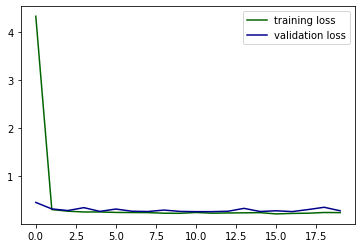

19/19 [==============================] - 2s 127ms/step - loss: 0.2659 - accuracy: 0.8667


[0.2658618986606598, 0.8666666746139526]

In [205]:
plt.plot(log_CNN_tuner.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_CNN_tuner.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# evalute the model on test set
model_tuner.evaluate(x_CNN_test, y_CNN_test)

Record the result to the dataframe and compare from Question6

In [206]:
df_model_record_val_accuracy['log_CNN_tuner'] = log_CNN_tuner.history['val_accuracy']
df_model_record_val_loss['log_CNN_tuner'] = log_CNN_tuner.history['val_loss']
df_model_record_trn_accuracy['log_CNN_tuner'] = log_CNN_tuner.history['accuracy']
df_model_record_trn_loss['log_CNN_tuner'] = log_CNN_tuner.history['loss']

### Method 2: add more structure on the research model

#### model 1: Adding more units within layers and more MaxPooling2D layers after each Conv2D layers

1. Pooling operation is a basic operation that is often used in convolutional neural networks. Many paradigm models will be followed by a pooling operation after the convolutional layer. In recent years, the more mainstream is the use of max-pooling, which is rarely used. Use average-pooling, so we refer to this to use
2. Some papers mention that the lower-level network is more responsive to detailed features. With the continuous processing of features, the higher-level network has a better response to abstract features. As a feature processing operation, pooling should also consider what the data before pooling is, what meaning the data represents, and what the correlation of the data is.
3. Therefore, our approach here is to add MaxPooling2D to the back of each layer of Conv2D, which should theoretically improve the signifiican of the signals and prevent overfitting.

In [171]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [172]:
input_shape = (100, 100, 1)
model_Max = Sequential([
    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid',input_shape=(100, 100, 1)), 
    MaxPooling2D(pool_size=(3,3)), # add MaxPooling2D to the back of each layer of Conv2D
    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid'),
    MaxPooling2D(pool_size=(3,3)), # add MaxPooling2D to the back of each layer of Conv2D
    tf.keras.layers.Dropout(rate=0.2),
    Conv2D(32, kernel_size=(3, 3),strides=2, padding='valid',activation='relu'),
    MaxPooling2D(pool_size=(3,3)), # add MaxPooling2D to the back of each layer of Conv2D
    Flatten(),
    Dense(4, activation='softmax')])

model_Max.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_Max.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          1

In [173]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_Max= model_Max.fit(x_CNN_trn, y_CNN_trn, 
                epochs=epochs,
                validation_data=(x_CNN_val, y_CNN_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 11s 121ms/step - loss: 5.1341 - accuracy: 0.2807 - val_loss: 1.2888 - val_accuracy: 0.4417
Epoch 2/20
88/88 [==============================] - 11s 129ms/step - loss: 1.2707 - accuracy: 0.3904 - val_loss: 1.1993 - val_accuracy: 0.4917
Epoch 3/20
88/88 [==============================] - 11s 128ms/step - loss: 1.1701 - accuracy: 0.4282 - val_loss: 1.0253 - val_accuracy: 0.4583
Epoch 4/20
88/88 [==============================] - 12s 133ms/step - loss: 1.0359 - accuracy: 0.5068 - val_loss: 0.8591 - val_accuracy: 0.5217
Epoch 5/20
88/88 [==============================] - 12s 133ms/step - loss: 0.7745 - accuracy: 0.6586 - val_loss: 0.4891 - val_accuracy: 0.8300
Epoch 6/20
88/88 [==============================] - 11s 128ms/step - loss: 0.4781 - accuracy: 0.8196 - val_loss: 0.3429 - val_accuracy: 0.8867
Epoch 7/20
88/88 [==============================] - 11s 123ms/step - loss: 0.3101 - accuracy: 0.8921 - val_loss: 0.2819 - val_accuracy: 0.8867

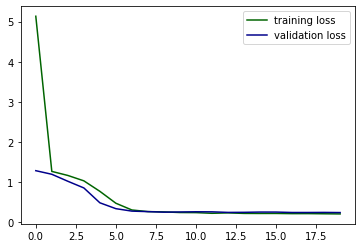

In [174]:
plt.plot(log_Max.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_Max.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# # evalute the model on test set
# model_mobilenet_V2.evaluate(x_preprocess_test, y_test)

1. Although the accuracy rate is not improved, the learning speed is much better comparing with the research model and tuning model above.
2. The accuracy rate is not improved but remian about the same as the research model

Though it is not the best model, but the result would also record to the dataframe

In [175]:
df_model_record_val_accuracy['log_Max'] = log_Max.history['val_accuracy']
df_model_record_val_loss['log_Max'] = log_Max.history['val_loss']
df_model_record_trn_accuracy['log_Max'] = log_Max.history['accuracy']
df_model_record_trn_loss['log_Max'] = log_Max.history['loss']

#### model 2: Adding BatchNormalization layers

Batch Normalization, similar to ordinary data normalization, is a method of unifying scattered data. Through BatchNormalization, the nerves can look down on data with uniform specifications, making it easier for machine learning to learn the laws in the data.\
We believe that after adding BatchNormalization, it can ensure that the training of each layer of neurons is more stable, and important training information will not be lost. And improve the accuracy of the model

In [176]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [177]:
input_shape = (100, 100, 1)
model_Max_adjust = Sequential([
    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid',input_shape=input_shape),
    BatchNormalization(), # BatchNormalization could prevent overfitting and be senestive to the input feature
    MaxPooling2D(pool_size=(3,3)),

    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(3,3)),


    tf.keras.layers.Dropout(rate=0.2), #dropout to also prevent overfitting
    Conv2D(32, kernel_size=(3, 3),strides=2, padding='valid',activation='relu'),

    #BatchNormalization(),
    MaxPooling2D(pool_size=(3,3)),

    Flatten(), # convert pixels to vector
    Dense(4, activation='softmax')])

model_Max_adjust.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #learning rate
              metrics=['accuracy'])
model_Max_adjust.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                        

In [178]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_Max_adjust= model_Max_adjust.fit(x_CNN_trn, y_CNN_trn, 
                epochs=epochs,
                validation_data=(x_CNN_val, y_CNN_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 17s 181ms/step - loss: 1.3395 - accuracy: 0.3979 - val_loss: 1.2899 - val_accuracy: 0.2650
Epoch 2/20
88/88 [==============================] - 14s 154ms/step - loss: 0.8203 - accuracy: 0.6800 - val_loss: 0.6471 - val_accuracy: 0.7800
Epoch 3/20
88/88 [==============================] - 14s 163ms/step - loss: 0.4299 - accuracy: 0.8439 - val_loss: 0.3537 - val_accuracy: 0.8883
Epoch 4/20
88/88 [==============================] - 14s 161ms/step - loss: 0.3232 - accuracy: 0.8800 - val_loss: 0.2938 - val_accuracy: 0.8867
Epoch 5/20
88/88 [==============================] - 15s 175ms/step - loss: 0.3041 - accuracy: 0.8850 - val_loss: 0.2951 - val_accuracy: 0.8817
Epoch 6/20
88/88 [==============================] - 14s 163ms/step - loss: 0.2832 - accuracy: 0.8904 - val_loss: 0.2928 - val_accuracy: 0.8867
Epoch 7/20
88/88 [==============================] - 15s 166ms/step - loss: 0.2724 - accuracy: 0.8896 - val_loss: 0.2795 - val_accuracy: 0.8867

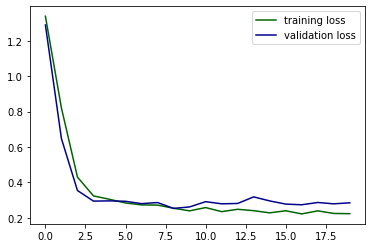

In [179]:
plt.plot(log_Max_adjust.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_Max_adjust.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# # evalute the model on test set
# model_mobilenet_V2.evaluate(x_preprocess_test, y_test)

 With 20 epcchs, we can observe:
1. loss: 0.2227 
2. accuracy: 0.8968 
3. val_loss: 0.2841 
4. val_accuracy: 0.8867
5. The execution time of each epoch is about 15 seconds

compare with the research model and other model above, adding BatchNormalization and max_pooling2d layers after each Conv2D layers:
1. would have the similiar and highest accuracy rate, 
2. though the execution time of each epoch increase a bit, the learning speed (especially for the validation set) is much better than the research model and other model above

We would also record the result to the dataframe:

In [180]:
df_model_record_val_accuracy['log_Max_adjust'] = log_Max_adjust.history['val_accuracy']
df_model_record_val_loss['log_Max_adjust'] = log_Max_adjust.history['val_loss']
df_model_record_trn_accuracy['log_Max_adjust'] = log_Max_adjust.history['accuracy']
df_model_record_trn_loss['log_Max_adjust'] = log_Max_adjust.history['loss']

### Method3: using other pre-train model

1. Here we consider two pre-train model, which are mobelnetV1 and mobelnetV2, and the explained reasons coould be found in the following:
2. Before apply the mobelnet, we would need to fit the shape of the input image, which is (160,160,3)
3. In order to do that, we use zoom to let the image become larger (the original is (100,100,1))
4. We would also scale the image to [0,1] as the gray-scale image to fit the model

In [49]:
time_series_CNN = np.append(time_series_1_reshape, time_series_2_reshape , axis=2)
print('time_series_1_reshape shape:', time_series_1_reshape.shape)
print('time_series_2_reshape shape:', time_series_2_reshape.shape)
print('time_series_stack_reshap shape:', time_series_CNN.shape)

time_series_1_reshape shape: (4000, 100, 50, 1)
time_series_2_reshape shape: (4000, 100, 50, 1)
time_series_stack_reshap shape: (4000, 100, 100, 1)


In [50]:
# scaling to [0,1] as the gray-scale image
x_preprocess = preprocess_input(time_series_CNN.copy())
x_preprocess.shape

(4000, 100, 100, 1)

In [51]:
print('Processing all the data to resized images:')
resized_images = []
for i in range(x_preprocess.shape[0]):
    resized_images.append(zoom(x_preprocess[i], (1.6, 1.6, 3.0)))
    if (i+1) % 200 == 0:
        print('* Processed %d images' % (i+1))
x_preprocess = np.stack(resized_images)

Processing all the data to resized images:
* Processed 200 images
* Processed 400 images
* Processed 600 images
* Processed 800 images
* Processed 1000 images
* Processed 1200 images
* Processed 1400 images
* Processed 1600 images
* Processed 1800 images
* Processed 2000 images
* Processed 2200 images
* Processed 2400 images
* Processed 2600 images
* Processed 2800 images
* Processed 3000 images
* Processed 3200 images
* Processed 3400 images
* Processed 3600 images
* Processed 3800 images
* Processed 4000 images


In [53]:
# trian val and test split
np.random.seed(123)
idx = np.arange(len(time_series_1))
np.random.shuffle(idx)

train = 2800
val = 600
test = 600
train_idxs = idx[:train]
val_idxs = idx[train:train+val]
test_idxs = idx[train+val:train+val+test]

x_preprocess_trn = x_preprocess[train_idxs]
x_preprocess_val = x_preprocess[val_idxs]
x_preprocess_test = x_preprocess[test_idxs]


y_trn = y[train_idxs]
y_val = y[val_idxs]
y_test = y[test_idxs]

#### mobelnetV1 

The reason why we apply a pre-trained model is that for the Trainable params would be much less than the research model since it is taken as a forzen layers.
In Generally speaking, the pre-trained model is more stable and computing power is more efficient.

Notice that:
1. The difference between GlobalAveragePooling and our usual average pooling is that GlobalAveragePooling takes the average value inside each feature map to each categories
2. FCNN is stack the data but not helping the summary
2. GlobalAveragePooling2D aggregates the data into matrix, summarizing the data for better interputation to softmax
4. MaxPooling1D takes a pool_length argument, whereas GlobalMaxPooling1D does not.

One advantage of global average pooling over the fully connected layers is that it is more native to the convolution structure by enforcing correspondences between feature maps and categories. Thus the feature maps can be easily interpreted as categories confidence maps. Another advantage is that there is no parameter to optimize in the global average pooling thus overfitting is avoided at this layer. Furthermore, global average pooling sums out the spatial information, thus it is more robust to spatial translations of the input.

In [54]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [55]:
#  use the pre-train mobilenet
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (160,160,3))
mobilenet.trainable = False # We would like to freeze the pre-trained model

model_mobilenet = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')])
    
model_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 4100      
                                                                 
Total params: 3,232,964
Trainable params: 4,100
Non-trainable params: 3,228,864
_________________________________________________________________


In [57]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_mobilenet= model_mobilenet.fit(x_preprocess_trn, y_trn, 
                epochs=epochs,
                validation_data=(x_preprocess_val, y_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 24s 257ms/step - loss: 1.2816 - accuracy: 0.4357 - val_loss: 1.1487 - val_accuracy: 0.5283
Epoch 2/20
88/88 [==============================] - 22s 249ms/step - loss: 1.0496 - accuracy: 0.6350 - val_loss: 1.0154 - val_accuracy: 0.6717
Epoch 3/20
88/88 [==============================] - 23s 262ms/step - loss: 0.9196 - accuracy: 0.7239 - val_loss: 0.9425 - val_accuracy: 0.6183
Epoch 4/20
88/88 [==============================] - 21s 239ms/step - loss: 0.8342 - accuracy: 0.7500 - val_loss: 0.8437 - val_accuracy: 0.7550
Epoch 5/20
88/88 [==============================] - 20s 229ms/step - loss: 0.7680 - accuracy: 0.7825 - val_loss: 0.7869 - val_accuracy: 0.7567
Epoch 6/20
88/88 [==============================] - 23s 257ms/step - loss: 0.7094 - accuracy: 0.8107 - val_loss: 0.7411 - val_accuracy: 0.7833
Epoch 7/20
88/88 [==============================] - 22s 247ms/step - loss: 0.6587 - accuracy: 0.8243 - val_loss: 0.6873 - val_accuracy: 0.8067

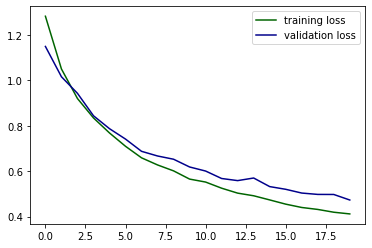

In [58]:
plt.plot(log_mobilenet.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_mobilenet.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

With 20 epcchs, we can observe:
1. loss: 0.4119
2. accuracy: 0.8854 
3. val_loss: 0.4730
4. val_accuracy: 0.8450
5. The execution time of each epoch is about 25 seconds

Observing:
1. From the plot we could see that the learning speed for both train and validation set is great.
2. but the execution time of each epoch is mot actually faster
3. the accuracy rate is not also very well (which is making sence since the model is not completely pefect suitable to our data)

But we would also record the result to the dataframe:

In [181]:
df_model_record_val_accuracy['log_mobilenet'] = log_mobilenet.history['val_accuracy']
df_model_record_val_loss['log_mobilenet'] = log_mobilenet.history['val_loss']
df_model_record_trn_accuracy['log_mobilenet'] = log_mobilenet.history['accuracy']
df_model_record_trn_loss['log_mobilenet'] = log_mobilenet.history['loss']

#### mobelnetV2

The reason why we are using the moblenetV2 is that 
1. It builds upon the ideas from MobileNetV1
2. MobileNetV2 is about 35 percent faster with the same accuracy than MobileNetV1
3. Linear bottlenecks between the layers: Experimental evidence suggests that using linear layers is crucial as it prevents nonlinearities from destroying too much information.

some researches claims that using non-linear layers in bottlenecks indeed hurts the performance by several percent, further validating our hypothesis. With the improvement from MobileNetV1 to add linear function between the layers. We believed that with adding the linear function between the layers, the model would be more stable and the accuracy rate would be higher.

In [63]:
# clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [64]:
mobilenet_v2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape = (160,160,3))
mobilenet_v2.trainable = False

model_mobilenet_V2 = Sequential([
    mobilenet_v2,
    GlobalAveragePooling2D(),
    Dense(4, activation='softmax')])
    
model_mobilenet_V2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_mobilenet_V2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [65]:
epochs = 20
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_mobilenet_v2= model_mobilenet_V2.fit(x_preprocess_trn, y_trn, 
                epochs=epochs,
                validation_data=(x_preprocess_val, y_val),
                # callbacks = [early_stopping_cb]
                )

Epoch 1/20
88/88 [==============================] - 22s 217ms/step - loss: 1.2710 - accuracy: 0.4221 - val_loss: 1.1854 - val_accuracy: 0.3983
Epoch 2/20
88/88 [==============================] - 22s 250ms/step - loss: 1.0589 - accuracy: 0.5821 - val_loss: 0.9978 - val_accuracy: 0.6400
Epoch 3/20
88/88 [==============================] - 21s 242ms/step - loss: 0.9405 - accuracy: 0.6643 - val_loss: 0.9956 - val_accuracy: 0.5567
Epoch 4/20
88/88 [==============================] - 20s 224ms/step - loss: 0.8672 - accuracy: 0.6964 - val_loss: 0.8989 - val_accuracy: 0.6750
Epoch 5/20
88/88 [==============================] - 20s 226ms/step - loss: 0.8210 - accuracy: 0.7150 - val_loss: 0.7829 - val_accuracy: 0.7400
Epoch 6/20
88/88 [==============================] - 22s 245ms/step - loss: 0.7601 - accuracy: 0.7457 - val_loss: 0.7495 - val_accuracy: 0.7650
Epoch 7/20
88/88 [==============================] - 23s 260ms/step - loss: 0.7134 - accuracy: 0.7664 - val_loss: 0.7299 - val_accuracy: 0.7183

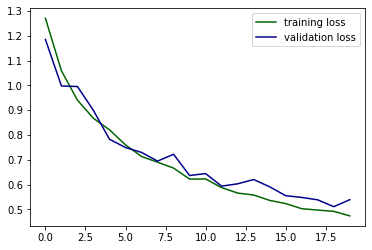

In [66]:
plt.plot(log_mobilenet_v2.history['loss'],label = "training loss",color='darkgreen')
plt.plot(log_mobilenet_v2.history['val_loss'], label = "validation loss",color='darkblue')
plt.legend()
ax = plt.gca()
plt.show()

# # evalute the model on test set
# model_mobilenet_V2.evaluate(x_preprocess_test, y_test)

With 20 epcchs, we can observe:
1. loss: 0.4737
2. accuracy: 0.8568 
3. val_loss: 0.5392
4. val_accuracy: 0.8283
5. The execution time of each epoch is about 20 seconds

Even though with adding linear function between the layers, the accuracy rate is not higher, and the val_loss is also not lower, but the execution time is improve a bit.

We would also record the result to the dataframe:

In [182]:
df_model_record_val_accuracy['log_mobilenet_v2'] = log_mobilenet_v2.history['val_accuracy']
df_model_record_val_loss['log_mobilenet_v2'] = log_mobilenet_v2.history['val_loss']
df_model_record_trn_accuracy['log_mobilenet_v2'] = log_mobilenet_v2.history['accuracy']
df_model_record_trn_loss['log_mobilenet_v2'] = log_mobilenet_v2.history['loss']

## Question 6
**Compare the models you have created so far (both RNNs and CNNs) and make a selection (making sure to justify this). Train that model on a combined training and validation set and evaluate it on your test set.**

### Justification for different models
Now we print out the result to see the difference of each model for both RNN and CNN with 20 epochs

In [189]:
df_model_record_val_accuracy

,log_optimal,log_optimal2,log_CNN,log_CNN_tuner,log_Max,log_Max_adjust,log_mobilenet,log_mobilenet_v2
0,0.643333,0.503333,0.845000,0.780000,0.441667,0.265000,0.528333,0.398333
1,0.845000,0.708333,0.883333,0.885000,0.491667,0.780000,0.671667,0.640000
2,0.883333,0.765000,0.871667,0.890000,0.458333,0.888333,0.618333,0.556667
3,0.870000,0.835000,0.876667,0.886667,0.521667,0.886667,0.755000,0.675000
4,0.880000,0.863333,0.886667,0.886667,0.830000,0.881667,0.756667,0.740000
5,0.885000,0.861667,0.885000,0.886667,0.886667,0.886667,0.783333,0.765000
6,0.888333,0.878333,0.883333,0.881667,0.886667,0.886667,0.806667,0.718333
7,0.886667,0.865000,0.888333,0.888333,0.886667,0.886667,0.815000,0.788333
8,0.883333,0.880000,0.888333,0.888333,0.886667,0.885000,0.813333,0.778333
9,0.886667,0.883333,0.886667,0.880000,0.886667,0.886667,0.823333,0.808333


The highest accuracy rate is the research model (log_CNN) and model_Max_adjust (log_Max_adjust), which are both 0.886667

In [185]:
df_model_record_val_loss

,log_optimal,log_optimal2,log_CNN,log_CNN_tuner,log_Max,log_Max_adjust,log_mobilenet,log_mobilenet_v2
0,0.814800,1.095198,0.454780,0.448551,1.288758,1.289903,1.148728,1.185398
1,0.447870,0.782346,0.392768,0.313031,1.199349,0.647131,1.015367,0.997839
2,0.316940,0.586961,0.419767,0.279234,1.025295,0.353720,0.942466,0.995605
3,0.357057,0.427329,0.362974,0.339721,0.859142,0.293755,0.843736,0.898927
4,0.297244,0.356360,0.336711,0.261695,0.489110,0.295091,0.786897,0.782867
5,0.265535,0.336955,0.424150,0.310762,0.342869,0.292796,0.741129,0.749517
6,0.262857,0.307267,0.327477,0.264908,0.281877,0.279491,0.687279,0.729860
7,0.262431,0.323927,0.279846,0.258984,0.269452,0.285643,0.666746,0.694733
8,0.272381,0.279094,0.264277,0.289050,0.256245,0.252527,0.652482,0.722377
9,0.283938,0.283591,0.308788,0.261269,0.260898,0.260934,0.618400,0.636757


The lowest validaiton loss ranking:
1. model_Max (log_Max) with val_loss: 0.246145
1. research model (log_CNN) with val_loss: 0.259568
2. model_Max_adjust (log_Max_adjust) with val_loss: 0.284147

In [186]:
df_model_record_trn_accuracy

,log_optimal,log_optimal2,log_CNN,log_CNN_tuner,log_Max,log_Max_adjust,log_mobilenet,log_mobilenet_v2
0,0.540000,0.410357,0.549643,0.667857,0.280714,0.397857,0.435714,0.422143
1,0.802500,0.601071,0.804286,0.885000,0.390357,0.680000,0.635000,0.582143
2,0.891786,0.749286,0.841071,0.887500,0.428214,0.843929,0.723929,0.664286
3,0.887143,0.829286,0.857143,0.888929,0.506786,0.880000,0.750000,0.696429
4,0.899286,0.876071,0.850357,0.887143,0.658571,0.885000,0.782500,0.715000
5,0.904286,0.889643,0.857143,0.891429,0.819643,0.890357,0.810714,0.745714
6,0.908571,0.899643,0.874643,0.898214,0.892143,0.889643,0.824286,0.766429
7,0.910000,0.902500,0.875000,0.893214,0.898929,0.894286,0.836429,0.777143
8,0.908214,0.907143,0.881071,0.897500,0.903214,0.894643,0.836071,0.777857
9,0.910000,0.908214,0.885357,0.905714,0.898571,0.902500,0.856071,0.808214


In [187]:
df_model_record_trn_loss

,log_optimal,log_optimal2,log_CNN,log_CNN_tuner,log_Max,log_Max_adjust,log_mobilenet,log_mobilenet_v2
0,1.089906,1.260466,4.319894,4.329035,5.134138,1.339463,1.281620,1.270995
1,0.583854,0.952367,0.749227,0.299704,1.270654,0.820276,1.049640,1.058875
2,0.326347,0.670108,0.584410,0.266001,1.170074,0.429870,0.919582,0.940546
3,0.295949,0.481168,0.547522,0.249489,1.035919,0.323173,0.834217,0.867232
4,0.272766,0.352080,0.523254,0.249770,0.774488,0.304085,0.768042,0.820993
5,0.241107,0.309780,0.482512,0.239878,0.478053,0.283234,0.709391,0.760146
6,0.225130,0.267846,0.374495,0.237392,0.310143,0.272423,0.658665,0.713389
7,0.209754,0.246990,0.335026,0.236558,0.269901,0.271234,0.627333,0.690302
8,0.214794,0.227774,0.291163,0.223950,0.262467,0.253440,0.601265,0.666613
9,0.207763,0.219678,0.273976,0.221571,0.246783,0.238657,0.565099,0.622187


The optimal model is the model_Max_adjust model (log_Max_adjust), and the reason is that:

1. model_Max_adjust model and research model are the two with the highest valiadation accuracy among all models
2. Mentioning about the lowest validaiton loss ranking, we can see that the model_Max_adjust model is the model with the top-three lowest validation loss
3. the most critical point is that the model_Max_adjust model have the better learning curve on both train and validation set comparing with the research model, which is not too fast to drop down the loss at the beginning of the training.

Behind the logic of building the model_Max_adjust model:
1. In recent years, the more mainstream is the use of max-pooling after the 2D convolution layers to improve the signifiican of the signals and prevent overfitting
2. The lower-level network is more responsive to detailed features. With the continuous processing of features, the higher-level network has a better response to abstract features.
3. To add MaxPooling2D to the back of each layer of Conv2D should theoretically improve the signifiican of the signals and also increase the accuracy.
4. We also believe that after adding BatchNormalization, it can ensure that the training of each layer of neurons is more stable, and important training information will not be lost. And improve the accuracy of the model. 
5. Also the time for each epoch is not too long, the computation power is efficient enough.

### Optimal model evaluating and saving the model

In [9]:
x_CNN_evaluate = np.concatenate((x_CNN_trn, x_CNN_val), axis=0)
y_CNN_evaluate = np.concatenate((y_CNN_trn, y_CNN_val), axis=0)
x_CNN_evaluate.shape, y_CNN_evaluate.shape

((3400, 100, 100, 1), (3400, 4))

In [10]:
## clean sessions and set seeds
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [11]:
input_shape = (100, 100, 1)
model_Max_adjust = Sequential([
    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid',input_shape=input_shape),
    BatchNormalization(), # BatchNormalization could prevent overfitting and be senestive to the input feature
    MaxPooling2D(pool_size=(3,3)),

    Conv2D(64, kernel_size=(3, 3),strides=1, padding='valid'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(3,3)),


    tf.keras.layers.Dropout(rate=0.2), #dropout to also prevent overfitting
    Conv2D(32, kernel_size=(3, 3),strides=2, padding='valid',activation='relu'),

    #BatchNormalization(),
    MaxPooling2D(pool_size=(3,3)),

    Flatten(), # convert pixels to vector
    Dense(4, activation='softmax')])

model_Max_adjust.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #learning rate
              metrics=['accuracy'])
model_Max_adjust.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 64)       256       
 hNormalization)                                                 
                                                        

2022-04-15 09:05:36.208917: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here we set the epoch as 10 since the dataset is large now (to prevent overfitting), and we would evaluate the model on the test set.

In [12]:
model_Max_adjust.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #learning rate
              metrics=['accuracy'])
epochs = 10
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
log_Q6_CNN = model_Max_adjust.fit(x_CNN_evaluate, y_CNN_evaluate, 
                epochs=epochs,
                # callbacks = [early_stopping_cb]
                )

Epoch 1/10
107/107 [==============================] - 18s 162ms/step - loss: 1.3878 - accuracy: 0.3721
Epoch 2/10
107/107 [==============================] - 18s 166ms/step - loss: 0.7397 - accuracy: 0.7038
Epoch 3/10
107/107 [==============================] - 17s 162ms/step - loss: 0.3880 - accuracy: 0.8550
Epoch 4/10
107/107 [==============================] - 18s 165ms/step - loss: 0.3090 - accuracy: 0.8829
Epoch 5/10
107/107 [==============================] - 18s 165ms/step - loss: 0.2835 - accuracy: 0.8841
Epoch 6/10
107/107 [==============================] - 17s 155ms/step - loss: 0.2708 - accuracy: 0.8862
Epoch 7/10
107/107 [==============================] - 16s 150ms/step - loss: 0.2682 - accuracy: 0.8832
Epoch 8/10
107/107 [==============================] - 17s 160ms/step - loss: 0.2713 - accuracy: 0.8903
Epoch 9/10
107/107 [==============================] - 15s 140ms/step - loss: 0.2520 - accuracy: 0.8891
Epoch 10/10
107/107 [==============================] - 15s 139ms/step - l

In [13]:
# evalute the model on test set
model_Max_adjust.evaluate(x_CNN_test, y_CNN_test)

19/19 [==============================] - 1s 38ms/step - loss: 0.2843 - accuracy: 0.8767


[0.28433507680892944, 0.8766666650772095]

The final test set evaluate result would be 0.8767 accuracy with the loss of 0.2843

### Save the model as an .h5-file for final model chosen in Question 6

In [14]:
# save the trained model 
model_Max_adjust.save("model_Max_adjust.h5")